In [1]:
from astropy.io import fits
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from astropy.wcs import WCS
# specutils packages
from specutils import Spectrum1D
from specutils.analysis import line_flux
from specutils.fitting import fit_generic_continuum
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from specutils.analysis import centroid
from specutils.analysis import moment
import warnings
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f7e6b9129a0>

In [2]:
# OUR PN
hdu = fits.open("../Spectra-lamostdr7/spec-56581-VB031N50V1_sp08-218.fits")
hdudata = hdu[0].data
wl = hdudata[2]
Flux = hdudata[0]

In [3]:
# Defining units astropy
rel_flux = u.def_unit('Relative~flux')
rel_flux.decompose()

Unit("Relative~flux")

Re-format this dataset into astropy quantities

In [4]:
lamb = wl * u.AA 
flux = Flux * rel_flux
spec = Spectrum1D(spectral_axis=lamb, flux=flux) 

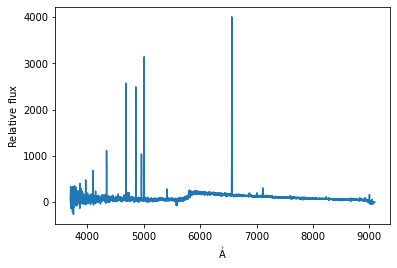

In [5]:
f, ax = plt.subplots()  
ax.step(spec.spectral_axis, spec.flux) 

**Now maybe you want the equivalent width of a spectral line. That requires normalizing by a continuum estimate:**

In [6]:
cont_norm_spec = spec / fit_generic_continuum(spec)(spec.spectral_axis) 

(6539.999999999999, 6569.999999999999)

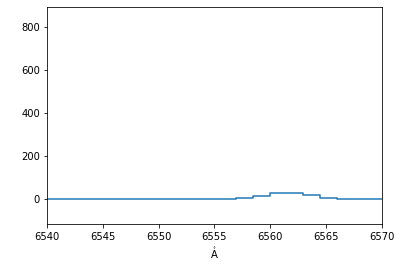

In [7]:
f, ax = plt.subplots()  
ax.step(cont_norm_spec.wavelength, cont_norm_spec.flux)  
ax.set_xlim(654 * u.nm, 657 * u.nm)  

In [8]:
equivalent_width(cont_norm_spec, regions=SpectralRegion(6556 * u.AA,  6569* u.AA)) 

<Quantity -142.27065999 Angstrom>

# **snr

In [9]:
#from specutils.analysis import snr
#snr(spec) 

### Line Flux Estimates

In [10]:
line_flux(spec, regions=SpectralRegion(6556 * u.AA,  6569* u.AA))  

<Quantity 21404.36737107 Angstrom Relative~flux>

In [11]:
centroid(spec, regions=SpectralRegion(6556 * u.AA,  6569* u.AA))  

<Quantity 6562.2637 Angstrom>

# Line/Spectrum Fitting

## Parameter Estimation

In [12]:
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region
from astropy.modeling import models

In [13]:
sub_region = SpectralRegion(6556 * u.AA,  6569* u.AA)
sub_spectrum = extract_region(spec, sub_region)

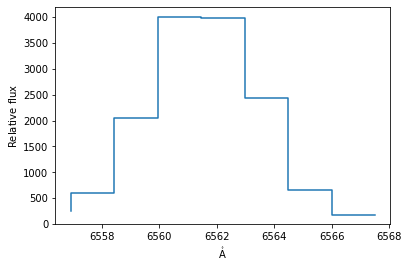

In [14]:
f, ax = plt.subplots()  
ax.step(sub_spectrum.spectral_axis, sub_spectrum.flux) 

In [15]:
print(estimate_line_parameters(sub_spectrum, models.Gaussian1D())) 

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       amplitude          mean            stddev      
     Relative~flux      Angstrom         Angstrom     
    ---------------- -------------- ------------------
    4004.78369140625 6562.263671875 2.0181450843811035


If an Model is used that does not have the predefined parameter estimators, or if one wants to use different parameter estimators then one can create a dictionary where the key is the parameter name and the value is a function that operates on a spectrum (lambda functions are very useful for this purpose). For example if one wants to estimate the line parameters of a line fit for a RickerWavelet1D one can define the estimators dictionary and use it to populate the estimator attribute of the model’s parameters:

## Model (Line) Fitting

In [16]:
from specutils.fitting import fit_lines
# Fit the spectrum and calculate the fitted flux values (``y_fit``)
g_init= models.Gaussian1D(amplitude=4004.78369140625 * rel_flux, mean=6562.263671875*u.AA, stddev=2.0181450843811035 * u.AA)
g_fit = fit_lines(spec, g_init, window=(6556 * u.AA,  6569* u.AA))
y_fit = g_fit(lamb)

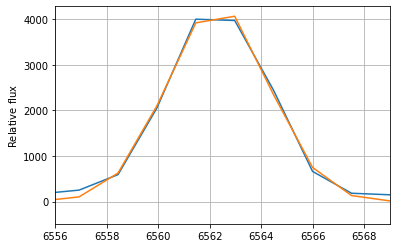

In [17]:
plt.plot(wl, Flux)
plt.plot(wl, y_fit)
plt.xlim(6556,  6569)
#plt.title('Single fit peak window')
plt.grid(True)

### Integrating over the Gaussian

In [18]:
gauss = Spectrum1D(spectral_axis=lamb, flux=y_fit) 
sub_gauss = extract_region(gauss, sub_region)


(6556.0, 6569.0)

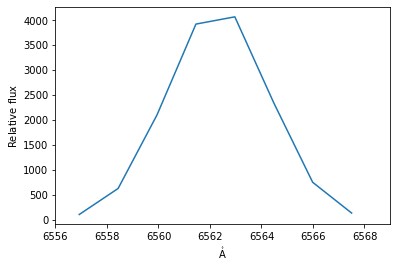

In [19]:
f, ax = plt.subplots()  
ax.plot(sub_gauss.spectral_axis, sub_gauss.flux) 
plt.xlim(6556,  6569)

In [20]:
 flux_line = np.trapz(sub_gauss.flux, sub_gauss.spectral_axis) 

In [21]:
 flux_line

<Quantity 21051.95099973 Angstrom Relative~flux>

### Using the sigma of Fit gaussian to calculate the window

In [22]:
min_lamb = 6562.2637 - 3*2.0181450843811035
max_lamb = 6562.2637 + 3*2.0181450843811035
sub_region0 = SpectralRegion(min_lamb * u.AA,  max_lamb * u.AA)

In [23]:
sub_gauss0 = extract_region(gauss, sub_region0)

(6556.0, 6569.0)

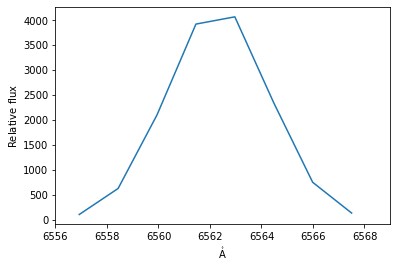

In [24]:
f, ax = plt.subplots()  
ax.plot(sub_gauss0.spectral_axis, sub_gauss0.flux) 
plt.xlim(6556,  6569)

In [25]:
 flux_line0 = np.trapz(sub_gauss0.flux, sub_gauss0.spectral_axis) 

In [26]:
 flux_line0

<Quantity 21051.95099973 Angstrom Relative~flux>

**Only using line center**

In [27]:
g_init1= models.Gaussian1D(mean=6561.45458984375*u.AA)
g_fit1 = fit_lines(spec, g_init1, window=(6556 * u.AA,  6569* u.AA))
y_fit1 = g_fit1(lamb)

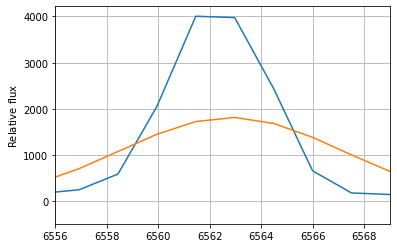

In [28]:
plt.plot(wl, Flux)
plt.plot(wl, y_fit1)
plt.xlim(6556,  6569)
#plt.title('Single fit peak window')
plt.grid(True)

In [29]:
gauss1 = Spectrum1D(spectral_axis=lamb, flux=y_fit1) 
sub_gauss1 = extract_region(gauss1, sub_region)


In [30]:
flux_line1 = np.trapz(sub_gauss1.flux, sub_gauss1.spectral_axis) 

In [31]:
flux_line1

<Quantity 15118.87527804 Angstrom Relative~flux>